**DEPENDÊNCIAS**
 - pip install tensorflow
 - pip install opencv-python

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os, cv2, random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

data/red/1200px-Traffic_lights_dark_red-svg.png


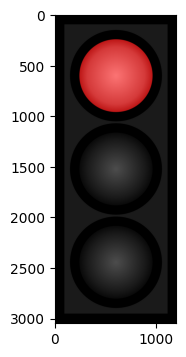

In [2]:
def plotImage(img):
    plt.figure(figsize=(20, 4))

    colored = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(colored)
    plt.show()


imgPath = 'data/red/' + os.listdir('data/red')[2]
print(imgPath)

img = cv2.imread(imgPath)
plotImage(img) 

# TRATAMENTO DE DADOS
- Removendo nas pastas de fotos todos os formatos indesejados ou arquivos corrompidos

In [3]:
dataDir    = 'data'
extensions = ['.jpeg', '.jpg', '.png']

In [4]:
for imageClass in os.listdir(dataDir):
    print('class: ', imageClass)
    folderPath = os.path.join(dataDir, imageClass)
    
    for image in os.listdir(folderPath):
        imagePath = os.path.join(folderPath, image)
        
        try:
            img = cv2.imread(imagePath) 
            file, imgType = os.path.splitext(image)

            if str(imgType).lower() not in extensions:
                print('excluido: ', imagePath)
                os.remove(imagePath)
        except Exception as e:
            print(f'erro ao ler {imagePath}: {e}')
            os.remove(imagePath)

class:  green
class:  red
class:  yellow


# EXTRAINDO OS DADOS
Possíveis Testes
- 16, 64, 16
- 32, 64
- 32, 64, 128
- 32, 64, 128, 256
- 16, 32, 64,
- 8, 16, 32
- 8, 16, 32, 64, 128

In [5]:
def createModel(data_dir, batch_size=32, epochs=10, sample=0.20):
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        validation_split=sample,
        rotation_range=40,
        width_shift_range=0.2, 
        height_shift_range=0.2, 
        shear_range=0.2, 
        zoom_range=0.2, 
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        channel_shift_range=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(200, 200),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(200, 200),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=True
    )

    model = Sequential([
        Input(shape=(200, 200, 3)),

        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        Dense(256, activation='relu'),
        Dense(train_generator.num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=epochs,
        callbacks=[checkpoint, early_stopping]
    )

    model = load_model('best_model.keras')
    return model, history, train_generator, validation_generator


model, history, trainGenerator, testGenerator = createModel('data/', batch_size=32, epochs=100)

Found 473 images belonging to 3 classes.
Found 116 images belonging to 3 classes.
Epoch 1/100


c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.3484 - loss: 1.3362

c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 1: val_loss improved from inf to 1.02790, saving model to best_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 597ms/step - accuracy: 0.3507 - loss: 1.3266 - val_accuracy: 0.5104 - val_loss: 1.0279
Epoch 2/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 11s 881ms/step - accuracy: 0.3750 - loss: 1.0715
Epoch 2: val_loss did not improve from 1.02790


c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3750 - loss: 1.0715 - val_accuracy: 0.2500 - val_loss: 1.0717
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.5134 - loss: 1.0072
Epoch 3: val_loss improved from 1.02790 to 0.85296, saving model to best_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 777ms/step - accuracy: 0.5145 - loss: 1.0052 - val_accuracy: 0.6250 - val_loss: 0.8530
Epoch 4/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.5000 - loss: 0.8704
Epoch 4: val_loss improved from 0.85296 to 0.76379, saving model to best_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 0.8704 - val_accuracy: 0.8000 - val_loss: 0.7638
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.6550 - loss: 0.8473
Epoch 5: val_loss improved from 0.76379 to 0.70413, saving model to best_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - accuracy: 0.6538 - loss: 0.8481 - val_accuracy: 0.7812 - val_loss: 0.7041
Epoch 6/100
 1/14

In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,555,979 (40.27 MB)

 Trainable params: 3,518,659 (13.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,037,320 (26.85 MB)

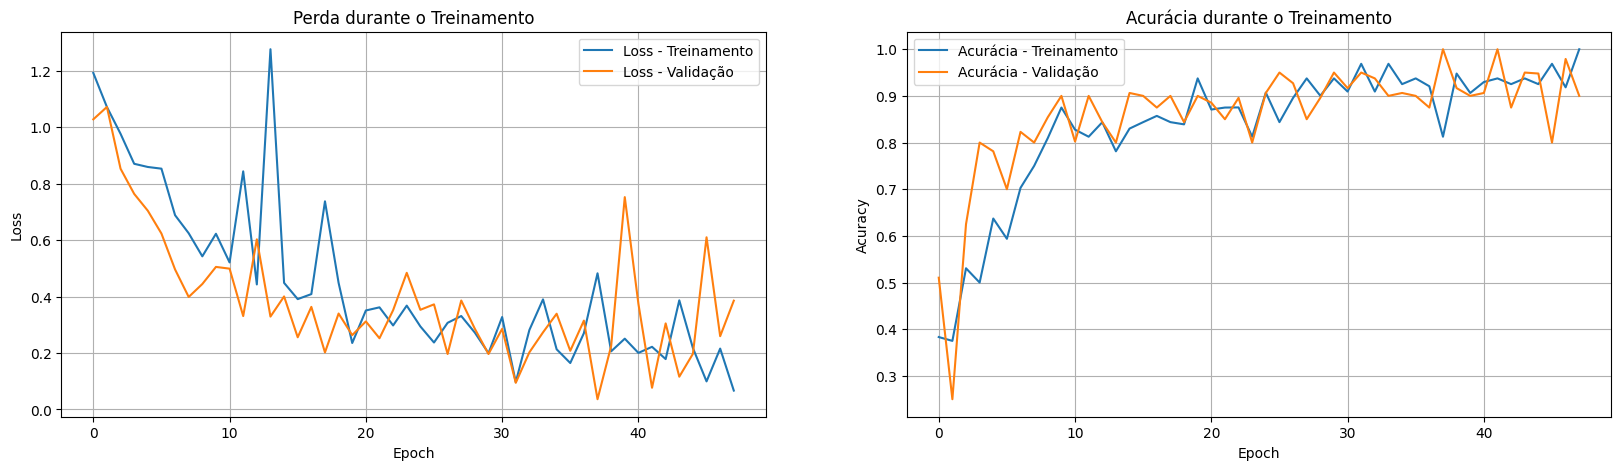

In [7]:
def plotDataLoss(history):
    plt.figure(figsize=(20, 5))

    # Plot para a perda
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss - Treinamento')
    plt.plot(history.history['val_loss'], label='Loss - Validação')
    plt.title('Perda durante o Treinamento')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot para a acurácia
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Acurácia - Treinamento')
    plt.plot(history.history['val_accuracy'], label='Acurácia - Validação')
    plt.title('Acurácia durante o Treinamento')
    plt.xlabel('Epoch')
    plt.ylabel('Acuracy')
    plt.legend()
    plt.grid()
    plt.show()


plotDataLoss(history) 

# TESTANDO O MODELO

In [3]:
model = load_model('best_model.keras')

In [6]:
class_indices = {
    'green': 0,
    'red': 1,
    'yellow': 2
}

In [8]:
def getKeyFromValue(data, target):
    for key, value in data.items():
        if target == value:
            return key
    return None


def processImage(file_path):
    img = load_img(file_path, target_size=(200, 200))  # Carregar e redimensionar a imagem
    img_array = img_to_array(img)                      # Converter a imagem para um array
    img_array = np.expand_dims(img_array, axis=0)      # Adicionar uma dimensão extra para o batch
    img_array /= 255.0                                 # Normalizar os pixels para o intervalo [0, 1]
    return img_array


def getPrediction(file_path):
    img = processImage(file_path)
    predict_matrix = model.predict(img)
    predicted_class = np.argmax(predict_matrix, axis=1)[0]  # Obter a classe com maior probabilidade
    probability     = predict_matrix[0][predicted_class]    # Obter a probabilidade da classe prevista
    return predicted_class, probability

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


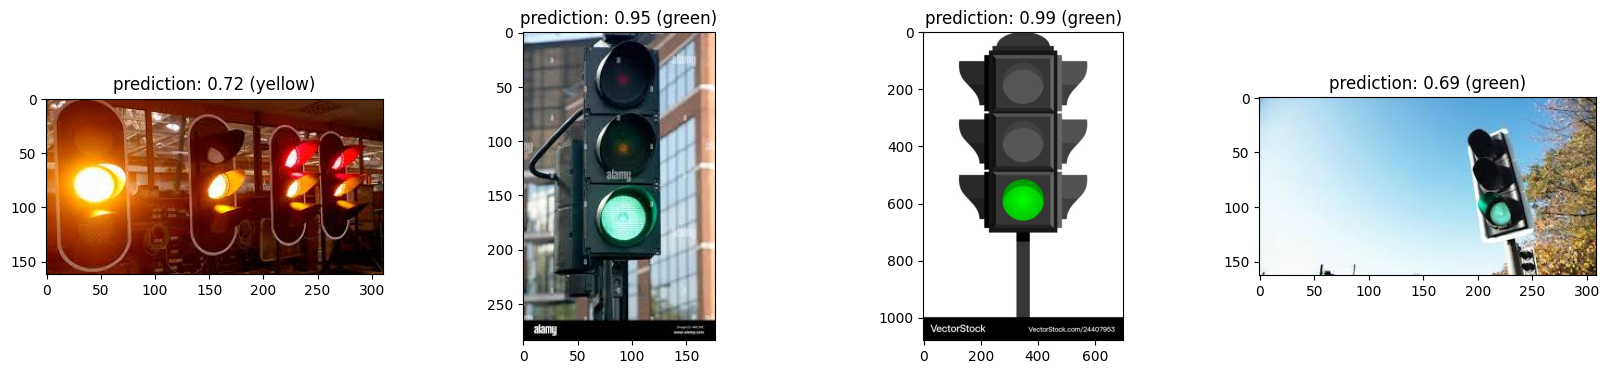

In [25]:
def findPath(path):
    return [path + file for file in os.listdir(path)]

files = findPath('data/green/') + findPath('data/red/') + findPath('data/yellow/') 
files = [random.choice(files) for i in range(4)]
fig, ax = plt.subplots(ncols=4, figsize=(20, 4))

for i, path in enumerate(files):    
    prediction = getPrediction(path)

    label = getKeyFromValue(class_indices, prediction[0])
    value = prediction[1]

    showImg = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    ax[i].imshow(showImg)
    ax[i].title.set_text(f'prediction: {value:.2f} ({label})')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


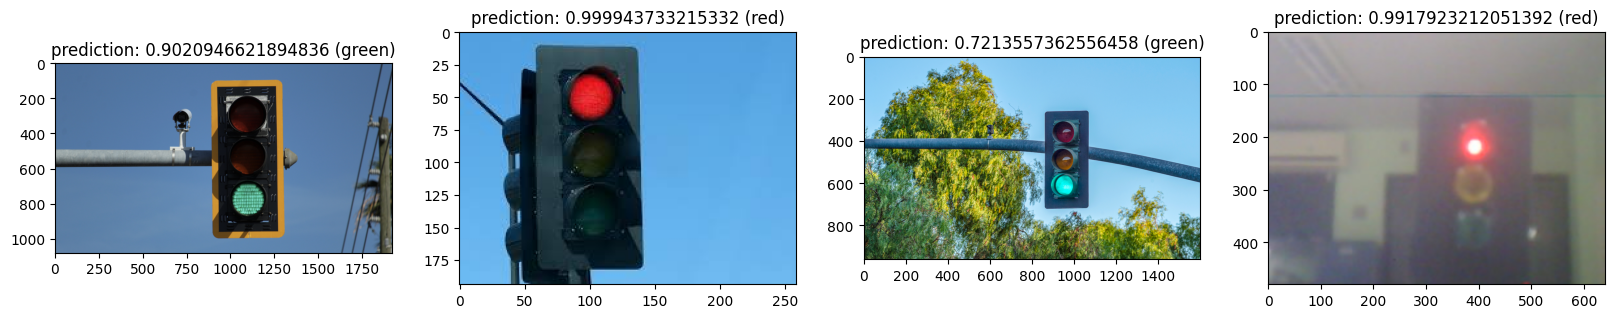

In [32]:
files   = os.listdir('test')
fig, ax = plt.subplots(ncols=4, figsize=(20, 4))

for i, file in enumerate(files):
    path = os.path.join('test', file)
    
    prediction = getPrediction(path)
    value = prediction[1]
    label = getKeyFromValue(class_indices, prediction[0])

    showImg = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    ax[i].imshow(showImg)
    ax[i].title.set_text(f'prediction: {value} ({label})')

In [13]:
predictions = {}

for imageClass in os.listdir(dataDir):
    folderPath = os.path.join(dataDir, imageClass)
    predictions[imageClass] = []
    
    for image in os.listdir(folderPath):
        imagePath = os.path.join(folderPath, image)
        
        prediction = getPrediction(imagePath)
        value = prediction[1]
        label = getKeyFromValue(class_indices, prediction[0])

        if predictions.get(imageClass) is None:
            continue

        predictions[imageClass] = predictions[imageClass] + [imageClass == label]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

In [14]:
sum(predictions['yellow'])

162

In [16]:
def getPercent(imageClass):
    prob = sum(predictions[imageClass]) / len(predictions[imageClass])
    return int(prob * 100)


print('red:    ', getPercent('red'), ' %')
print('yellow: ', getPercent('yellow'), ' %')
print('green:  ', getPercent('green'), ' %')

red:     99  %
yellow:  96  %
green:   93  %
